# UMBC Academic Graph — Synthetic Data EDA (from local generator)

This notebook walks **cell-by-cell** through:
1. Importing the local generator `generate_synthetic_data.py`
2. Generating data (dict **and** CSVs)
3. Loading CSVs into pandas
4. Basic analysis / quick visuals (students, courses, grades)
5. A tiny NetworkX projection (courses + prerequisites) for graph stats

Run the cells in order. Charts use plain **matplotlib**.

## 2) Load CSVs to pandas
This mirrors how you might inspect data before pushing into Neo4j or ML feature pipelines.

In [ ]:
import pandas as pd
import os
OUT_DIR = "umbc_data/csv"

def load_df(name):
    return pd.read_csv(os.path.join(OUT_DIR, name))

students_df = load_df('students.csv')
courses_df = load_df('courses.csv')
degrees_df = load_df('degrees.csv')
terms_df = load_df('terms.csv')
faculty_df = load_df('faculty.csv')
req_df = load_df('requirement_groups.csv')
prereq_df = load_df('prerequisites.csv')
leads_df = load_df('leads_to.csv')
simc_df = load_df('course_similarity_content.csv')
simd_df = load_df('course_similarity_difficulty.csv')
stu_deg_df = load_df('student_degree.csv')
teach_df = load_df('teaching.csv') if os.path.exists(os.path.join(OUT_DIR,'teaching.csv')) else None
completed_df = load_df('completed_courses.csv')
enrolled_df = load_df('enrolled_courses.csv')

print(students_df.shape, courses_df.shape, completed_df.shape)  # sanity check
print(students_df.head(3))

# --- Normalize IDs to friendly names across the key tables ---

# Students
if 'id:ID(Student)' in students_df.columns:
    students_df = students_df.rename(columns={'id:ID(Student)': 'studentId'})

# Courses
if 'id:ID(Course)' in courses_df.columns:
    courses_df = courses_df.rename(columns={'id:ID(Course)': 'courseId'})

# Completed courses (edges)
completed_renames = {}
if ':START_ID(Student)' in completed_df.columns:
    completed_renames[':START_ID(Student)'] = 'studentId'
if ':END_ID(Course)' in completed_df.columns:
    completed_renames[':END_ID(Course)'] = 'courseId'
if completed_renames:
    completed_df = completed_df.rename(columns=completed_renames)

# Optional: coerce the typed numeric columns if they exist
for c in ['difficulty:int', 'timeSpent:int', 'enjoyment:int']:
    if c in completed_df.columns:
        completed_df[c] = pd.to_numeric(completed_df[c], errors='coerce')

# Sanity check
print("completed_df columns:", list(completed_df.columns)[:12])
print("students_df columns:", list(students_df.columns)[:12])
print("courses_df columns:", list(courses_df.columns)[:12])


Note: you may need to restart the kernel to use updated packages.
(500, 10) (100, 14) (4327, 9)
  id:ID(Student)                name enrollmentDate expectedGraduation  \
0        QB79532  Christopher Cooper     2025-06-17         2026-03-03   
1        IW07367  Mercedes Patterson     2025-08-16         2027-12-05   
2        QM06211          Nicole Ray     2025-12-01         2029-05-08   

     learningStyle  preferredCourseLoad:int preferredPace  \
0  Reading-Writing                        5      Standard   
1      Kinesthetic                        3      Standard   
2  Reading-Writing                        3   Accelerated   

   workHoursPerWeek:int financialAidStatus preferredInstructionMode  
0                    10              Loans                   Hybrid  
1                     8       FinancialAid                   Hybrid  
2                     0        Scholarship                In-person  
completed_df columns: ['studentId', 'courseId', ':TYPE', 'term', 'grade', 'difficu

## 3) Quick distributions & sanity plots
* Students by learning style and instruction preference
* Course level/difficulty/time
* Grade distribution (from `completed_courses.csv`)

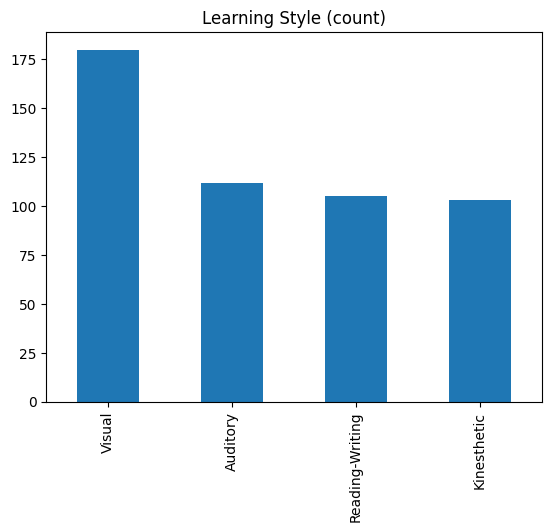

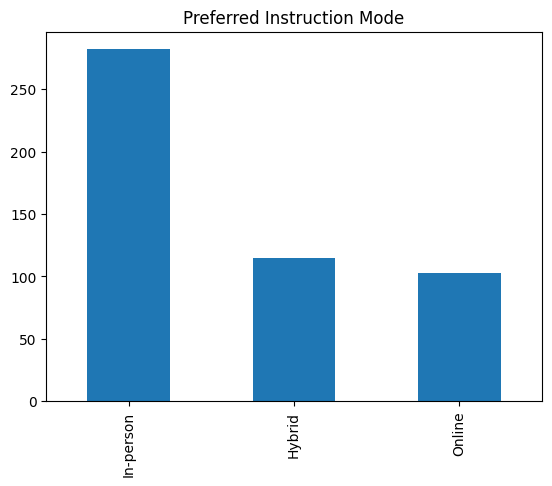

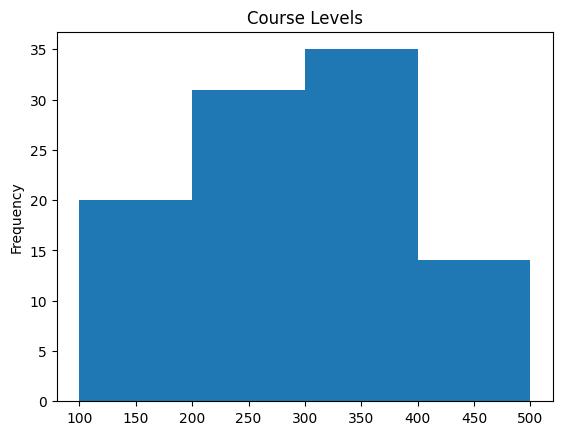

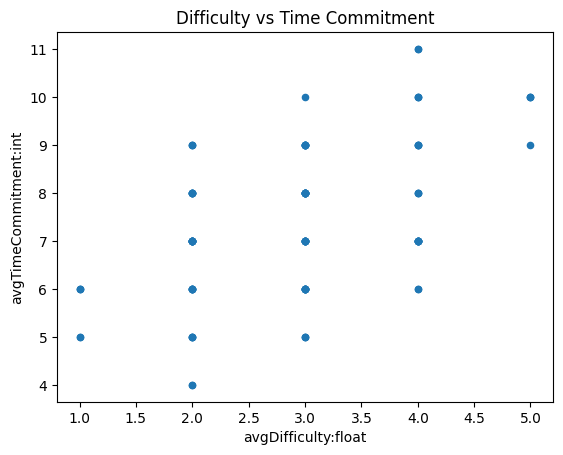

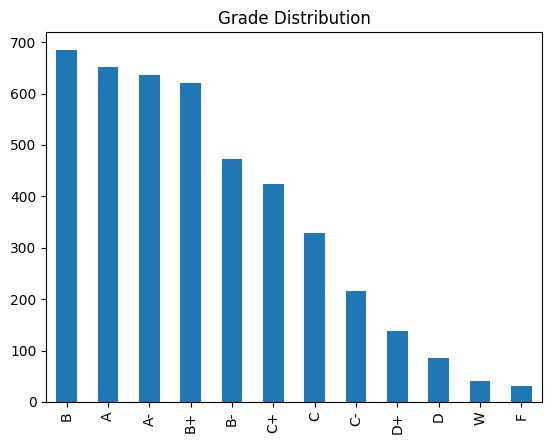

In [17]:
import matplotlib.pyplot as plt

# Students by learning style
students_df['learningStyle'].value_counts().plot(kind='bar'); plt.title('Learning Style (count)'); plt.xlabel(''); plt.show()

# Instruction mode preference
students_df['preferredInstructionMode'].value_counts().plot(kind='bar'); plt.title('Preferred Instruction Mode'); plt.xlabel(''); plt.show()

# Course level distribution
courses_df['level:int' if 'level:int' in courses_df.columns else 'level'].plot.hist(bins=[100,200,300,400,500]); plt.title('Course Levels'); plt.show()

# Difficulty vs time commitment
xcol = 'avgDifficulty:float' if 'avgDifficulty:float' in courses_df.columns else 'avgDifficulty'
ycol = 'avgTimeCommitment:int' if 'avgTimeCommitment:int' in courses_df.columns else 'avgTimeCommitment'
courses_df.plot.scatter(x=xcol, y=ycol); plt.title('Difficulty vs Time Commitment'); plt.show()

# Grades distribution
completed_df['grade'].value_counts().plot(kind='bar'); plt.title('Grade Distribution'); plt.xlabel(''); plt.show()

## 4) Simple derived metrics
Map letter grades to GPA, compute per-student GPA, and join with learning style to spot patterns.

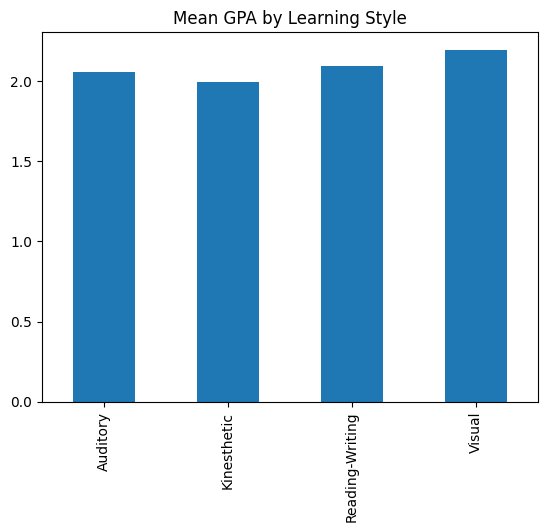

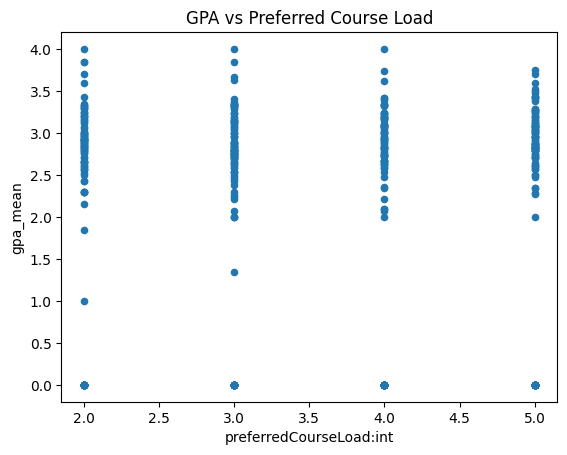

In [19]:
grade_map = {"A":4.0,"A-":3.7,"B+":3.3,"B":3.0,"B-":2.7,"C+":2.3,"C":2.0,"C-":1.7,
             "D+":1.3,"D":1.0,"D-":0.7,"F":0.0,"W":0.0}

completed_df['gpa'] = completed_df['grade'].map(grade_map).fillna(0)

# Group by the normalized studentId and count courses via courseId
stu_gpa = (
    completed_df
    .groupby('studentId', dropna=False)
    .agg(gpa_mean=('gpa','mean'), n_courses=('courseId','count'))
    .reset_index()
)

# Merge with normalized student table
merged = students_df.merge(stu_gpa, on='studentId', how='left')
merged['gpa_mean'] = merged['gpa_mean'].fillna(0)

# Plot examples
merged.groupby('learningStyle')['gpa_mean'].mean().plot(kind='bar')
plt.title('Mean GPA by Learning Style'); plt.xlabel(''); plt.show()

# Handle preferredCourseLoad with possible typed header
load_col = 'preferredCourseLoad:int' if 'preferredCourseLoad:int' in merged.columns else 'preferredCourseLoad'
merged.plot.scatter(x=load_col, y='gpa_mean')
plt.title('GPA vs Preferred Course Load'); plt.show()


## 5) Tiny course graph (NetworkX)
Use prerequisites to make a directed course graph, compute centralities, and peek at a subgraph plot.

Nodes: 100 | Edges: 116


,courseId,deg,pr
0,BZZZ 400,0.050505,0.040318
1,BMMM 100,0.040404,0.039703
2,BZZZ 400-3,0.020202,0.024624
3,BUUU 200,0.040404,0.024306
4,CSXX 400,0.030303,0.021452
5,BDDD 400,0.030303,0.021317
6,BFFF 300,0.020202,0.020389
7,CSUU 400,0.020202,0.019580
8,CSQQ 400,0.020202,0.018507
9,CSGG 400,0.030303,0.018379


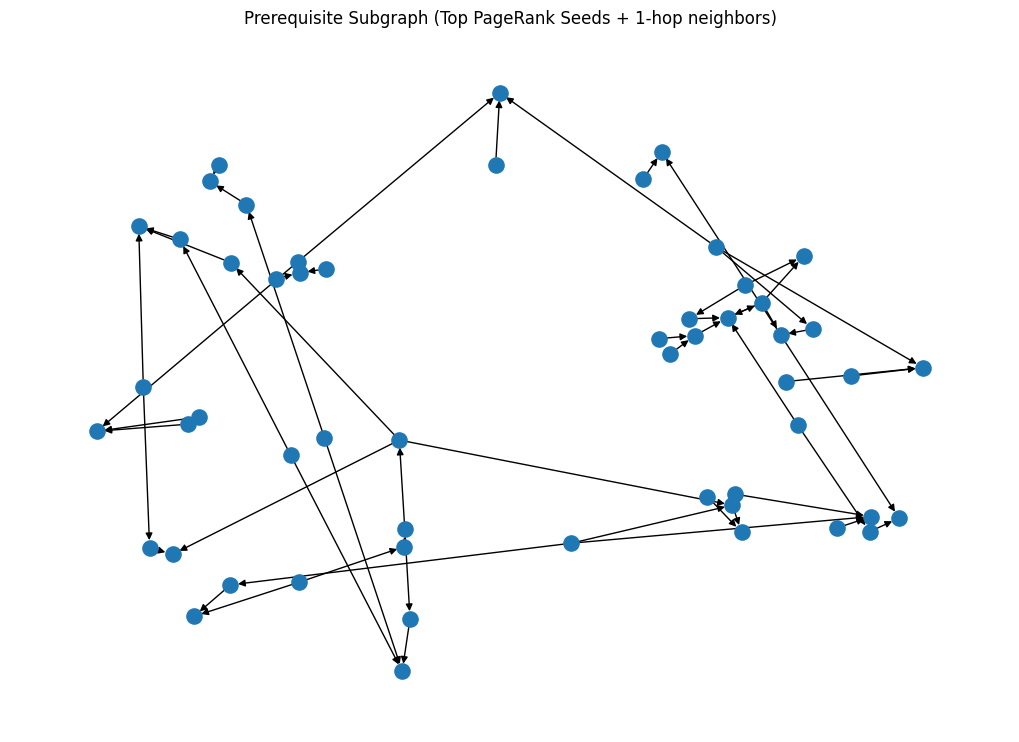

In [23]:
# --- Build a clean course prereq graph (robust to header variants) ---
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1) Normalize column names once
courses_df = courses_df.rename(columns={
    'id:ID(Course)': 'courseId'
}) if 'id:ID(Course)' in courses_df.columns else courses_df.rename(columns={'id': 'courseId'})

prereq_df = prereq_df.rename(columns={
    ':START_ID(Course)': 'src',
    ':END_ID(Course)': 'dst'
})  # if these already exist, rename does nothing

# Sanity checks
assert 'courseId' in courses_df.columns, "courses_df needs 'courseId' after normalization."
assert {'src','dst'}.issubset(prereq_df.columns), "prereq_df needs 'src' and 'dst' columns."

# 2) Clean types and filter to known courses
courses_df['courseId'] = courses_df['courseId'].astype(str)
prereq_df['src'] = prereq_df['src'].astype(str)
prereq_df['dst'] = prereq_df['dst'].astype(str)

course_ids = set(courses_df['courseId'].unique())
edges = prereq_df[['src','dst']].dropna().query('src != dst')
edges = edges[edges['src'].isin(course_ids) & edges['dst'].isin(course_ids)]

# 3) Build DiGraph
G = nx.DiGraph()
G.add_nodes_from(course_ids)
G.add_edges_from(edges.itertuples(index=False, name=None))  # (src, dst)

# Optional: remove any self-loops (should be none after query)
G.remove_edges_from(nx.selfloop_edges(G))

# Report basic info
print(f"Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")
if G.number_of_edges() == 0:
    print("Warning: No edges after filtering; check prereq_df headers or data generation.")
    
# 4) Centralities with guards for empty graphs
if G.number_of_edges() > 0 and G.number_of_nodes() > 0:
    deg_c = nx.degree_centrality(G)
    try:
        pr_c = nx.pagerank(G)  # for directed graphs; uses alpha=0.85 by default
    except nx.PowerIterationFailedConvergence:
        # Fallback: use undirected PageRank if directed PR fails on sparse/disconnected graphs
        pr_c = nx.pagerank(G.to_undirected())

    cen_df = pd.DataFrame({
        'courseId': list(deg_c.keys()),
        'deg': list(deg_c.values()),
        'pr': [pr_c.get(n, 0.0) for n in deg_c.keys()],
    }).sort_values('pr', ascending=False, ignore_index=True)

    display(cen_df.head(10))

    # 5) Visualize a small, meaningful subgraph: top-PR nodes + their immediate neighborhood
    topN = 20
    seeds = cen_df.head(topN)['courseId'].tolist()
    nbrs = set(seeds)
    for s in seeds:
        nbrs.update(G.predecessors(s))
        nbrs.update(G.successors(s))
    H = G.subgraph(nbrs).copy()

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(H, seed=0)
    nx.draw(H, pos, with_labels=False, node_size=120)
    plt.title('Prerequisite Subgraph (Top PageRank Seeds + 1-hop neighbors)')
    plt.show()
else:
    cen_df = pd.DataFrame(columns=['courseId', 'deg', 'pr'])
    display(cen_df)


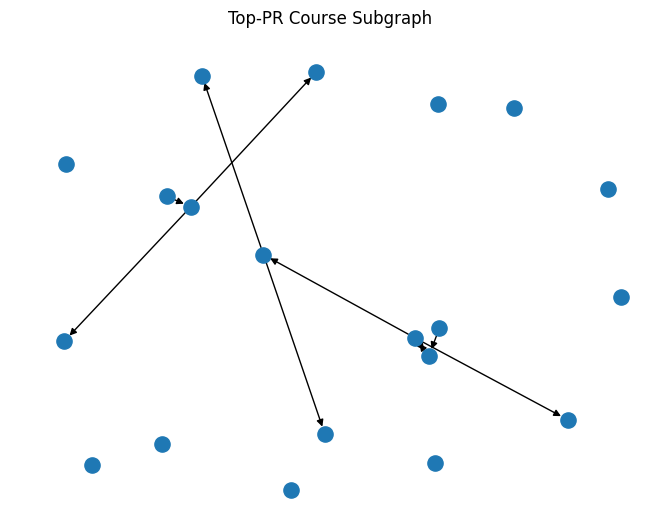

In [24]:
# Visualize a small subgraph (top PageRank courses)
top_nodes = cen_df.head(20)['courseId'].tolist()
H = G.subgraph(top_nodes).copy()
pos = nx.spring_layout(H, seed=0)
nx.draw(H, pos, with_labels=False, node_size=120)
plt.title('Top-PR Course Subgraph'); plt.show()

## 6) Course outcomes by difficulty/time
Join course metadata to completions and see how pass rate varies with difficulty/time.

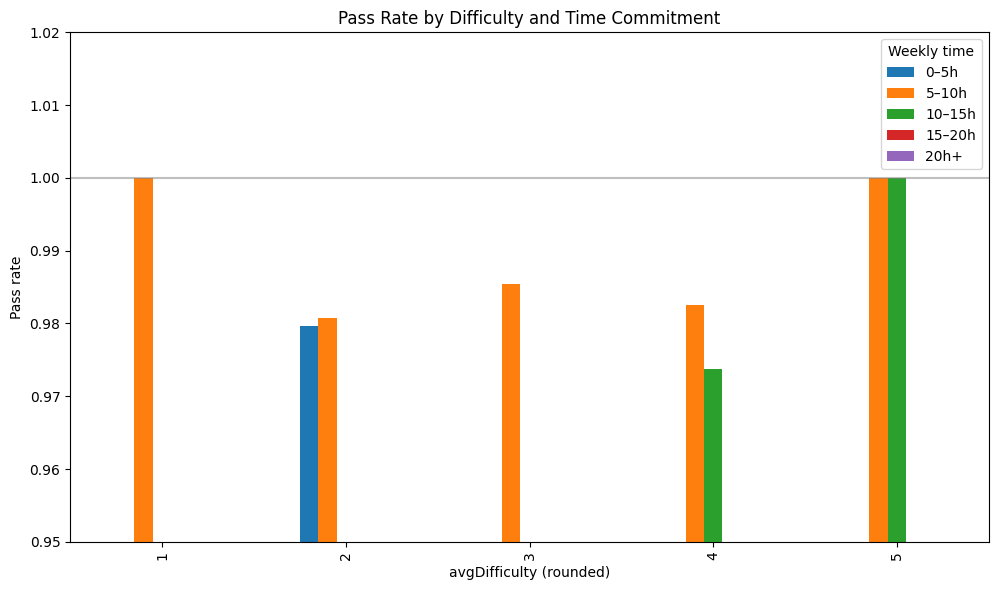

timeBin,0–5h,5–10h,10–15h,15–20h,20h+
diffRound,,,,,
1,NaN,1.000000,NaN,NaN,NaN
2,0.979592,0.980769,NaN,NaN,NaN
3,NaN,0.985458,NaN,NaN,NaN
4,NaN,0.982571,0.973684,NaN,NaN
5,NaN,1.000000,1.000000,NaN,NaN


In [38]:
# --- Pass rate by course difficulty & time commitment (robust) ---

# 1) Normalize course columns to friendly names
cdf = courses_df.copy()
rename_map = {
    'id:ID(Course)': 'courseId',
    'avgDifficulty:float': 'avgDifficulty',
    'avgTimeCommitment:int': 'avgTimeCommitment',
    'avgTimeCommitment:float': 'avgTimeCommitment',
}
cdf = cdf.rename(columns={k:v for k,v in rename_map.items() if k in cdf.columns})
if 'courseId' not in cdf.columns:
    cdf = cdf.rename(columns={'id':'courseId'})

# 2) Ensure completed_df already has 'courseId' (earlier we normalized START/END IDs).
# If not, uncomment the lines below:
# if ':END_ID(Course)' in completed_df.columns:
#     completed_df = completed_df.rename(columns={':END_ID(Course)':'courseId'})
# if ':START_ID(Student)' in completed_df.columns:
#     completed_df = completed_df.rename(columns={':START_ID(Student)':'studentId'})

# 3) Coerce numeric columns (errors='coerce' turns bad values into NaN)
for col in ['avgDifficulty','avgTimeCommitment']:
    if col in cdf.columns:
        cdf[col] = pd.to_numeric(cdf[col], errors='coerce')

# 4) Merge completions with course metadata
cols_needed = ['courseId','avgDifficulty','avgTimeCommitment']
missing_cols = [c for c in cols_needed if c not in cdf.columns]
assert not missing_cols, f"courses_df is missing: {missing_cols}"
tmp = completed_df.merge(cdf[cols_needed], on='courseId', how='left')

# 5) Build pass/fail
pass_grades = {'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-'}
tmp['passed'] = tmp['grade'].isin(pass_grades).astype(int)

# 6) Drop rows with missing difficulty or time (or choose to fill with medians)
tmp = tmp.dropna(subset=['avgDifficulty','avgTimeCommitment'])

# 7) Create interpretable time bins
bins = [0, 5, 10, 15, 20, np.inf]
labels = ['0–5h', '5–10h', '10–15h', '15–20h', '20h+']
tmp['timeBin'] = pd.cut(tmp['avgTimeCommitment'], bins=bins, labels=labels, right=False, include_lowest=True)

# 8) Aggregate pass rate by (difficulty, time bin)
# Round difficulty so bars aren’t too granular (optional)
tmp['diffRound'] = tmp['avgDifficulty'].round(1)
agg = (tmp
       .groupby(['diffRound','timeBin'], observed=False)['passed']
       .mean()
       .reset_index())

# 9) Pivot for plotting
agg_pivot = agg.pivot(index='diffRound', columns='timeBin', values='passed').sort_index()

# 10) Plot
ax = agg_pivot.fillna(0).plot(kind='bar', figsize=(10,6))
ax.set_title('Pass Rate by Difficulty and Time Commitment')
ax.set_xlabel('avgDifficulty (rounded)')
ax.set_ylabel('Pass rate')
ax.legend(title='Weekly time')
plt.tight_layout()
plt.axhline(1.0, c='gray', alpha=0.5)
plt.ylim(0.95,1.02)
plt.show()

# Optional: quick sanity peek
display(agg_pivot.head())


## 7) Where to take this next
- Export this feature table for ML (e.g., pass prediction)
- Build Node2Vec/GraphSAGE embeddings on the course graph and join back
- Add fairness slices (aid status, instruction mode)
- Link prediction sketch using pairs from `enrolled_courses.csv` vs historical completions